# NICE with tf==2.4.1 & tfp==0.12.1


### Paper: https://arxiv.org/pdf/1410.8516.pdf
### Implementation inspiration: https://github.com/DakshIdnani/pytorch-nice

## Import modules

In [1]:
from os import path
import numpy as np 
import pandas as pd

import tensorflow as tf 
from tensorflow import keras
import tensorflow_probability as tfp
tfd = tfp.distributions

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Load data

In [3]:
data_path = "mnist_784.csv"

In [4]:
if path.exists(data_path):
    data = pd.read_csv(data_path)
    X, y = data.iloc[:,:-1].values/255, data.iloc[:,-1].values/255
    X, y = X+np.random.uniform(0,1/256,(X.shape[0],X.shape[1])), y+np.random.uniform(0,1/256,y.shape)
else:
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    X, y = X/255, y.astype(np.float)/255
    X, y = X+np.random.uniform(0,1/256,(X.shape[0],X.shape[1])), y+np.random.uniform(0,1/256,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

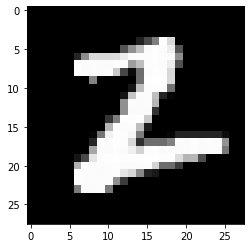

In [5]:
plt.imshow(X_train[0,:].reshape(28,28),cmap='gray')
plt.show()

## Model

In [6]:
class ScaleLayer(tf.keras.layers.Layer):
    """Layer that performs scaling."""
    def __init__(self,dim):
        super(ScaleLayer, self).__init__()
        w_init = tf.ones_initializer()
        self.S = tf.Variable(
            initial_value=w_init(shape=(dim), dtype="float32"),
            trainable=True,
        )

    def call(self, h,log_det_jacob=0, inverse=False):
        if inverse == True:
            y = tf.multiply(tf.math.exp(-self.S),h)
            return y
        h = tf.multiply(tf.math.exp(self.S),h)
        log_det_jacob = tf.math.reduce_sum(self.S)
        return h, log_det_jacob

In [7]:
class Linear(keras.layers.Layer):
    """y = w.x + b"""
    def __init__(self,name,units=32, input_dim=32):
        super(Linear, self).__init__()
        self.w = self.add_weight(name + "_weight",
                               shape=[input_dim, units],
                               regularizer=tf.keras.regularizers.l1_l2(.0001))
        self.b = self.add_weight(name + "_bias",
                               shape=[units],
                               regularizer=tf.keras.regularizers.l1_l2(.0001))

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [8]:
class AdditiveCouple(tf.keras.layers.Layer):
    def __init__(self,name, dim, mask,couple_dim):
        super(AdditiveCouple, self).__init__()
        
        self.dim = dim
        self.couple_dim = couple_dim
        self.mask = mask
        
        # Declare layers of NeuralNet~m
        self.l1 = Linear(name+'1',self.couple_dim,self.dim)
        self.l2 = Linear(name+'2',self.couple_dim,self.couple_dim)
        self.l3 = Linear(name+'3',self.couple_dim,self.couple_dim)
        self.l4 = Linear(name+'4',self.couple_dim,self.couple_dim)
        self.l5 = Linear(name+'5',self.dim,self.couple_dim)

    def m(self,x):
        x = self.l1(x)
        x = tf.nn.leaky_relu(x)
        x = self.l2(x)
        x = tf.nn.leaky_relu(x)
        x = self.l3(x)
        x = tf.nn.leaky_relu(x)
        x = self.l4(x)
        x = tf.nn.leaky_relu(x)
        return self.l5(x)

    def call(self, x, inverse=False):
        if inverse == True:
            y1, y2 = self.mask*x, (1-self.mask)*x 
            x1, x2 = y1, y2-(self.m(y1)*(1-self.mask))
            return x1+x2
        else:
            x1, x2 = self.mask*x, (1-self.mask)*x
            y1, y2 = x1, x2+(self.m(x1)*(1-self.mask))
            return y1+y2

In [9]:
class NICE(keras.Model):
    def __init__(self,input_dim,n_couple, couple_dim,**kwargs):
        super(NICE, self).__init__(**kwargs)

        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.prior = tfp.distributions.Logistic(0,1)
        
        self.input_dim = input_dim
        self.n_couple = n_couple
        self.couple_dim = couple_dim

        masks = [self._get_mask(self.input_dim, orientation=(i % 2 == 0)) for i in range(self.n_couple)]
        
        # Declare coupling layers
        self.coupling_layers = []
        for i in range(self.n_couple-1):
            add_couple = AdditiveCouple(str(i) ,self.input_dim,masks[i],self.couple_dim)
            self.coupling_layers.append(add_couple)
        
        # Declare Scaling layer
        self.S = ScaleLayer(dim=input_dim)

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def _get_mask(self, dim, orientation=True):
        mask = np.zeros(dim)
        mask[::2] = 1.
        if orientation:
            mask = 1. - mask  # flip mask orientation
        return mask
        
    def train_step(self, data):
        X, y = data[0], data[1]
        with tf.GradientTape() as tape:
            # Feed input through model 
            h, s_vals = self(X)
            
            # Caculate loss, prior is standard logistic
            loss = s_vals + tf.math.reduce_sum(self.prior.log_prob(h),axis=1)
            loss = -tf.math.reduce_mean(loss)
            
        grads = tape.gradient(loss, self.trainable_weights)
        #grads = [tf.clip_by_norm(g, 1)for g in grads]
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {
            "log_likelihood": self.loss_tracker.result(),
        }

    def test_step(self, data):
        X, y = data[0], data[1]
        h, s_vals = self(X)
        loss = s_vals + tf.math.reduce_sum(self.prior.log_prob(h),axis=1)
        loss = -tf.math.reduce_mean(loss)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
    def call(self,x,inverse=False,pass_inv=False):
        log_det_jacob = 0
        if inverse == True:
            if pass_inv == False:
                h = np.random.logistic(x,1, self.input_dim)
                h = np.reshape(h,(1,self.input_dim))
            elif pass_inv == True:
                h = x

            x = self.S(h,inverse=True)
            for layer in reversed(self.coupling_layers):
                x = layer(x,inverse=True)
            return x
        else:
            for layer in self.coupling_layers:
                x = layer(x)
            h, log_det_jacob = self.S(x,log_det_jacob)
            return h, log_det_jacob

## Fit model

In [10]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model = NICE(input_dim=784,n_couple=4,couple_dim=1000)
model.compile(optimizer=opt)

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),\
                    epochs=100, batch_size=200)

Epoch 1/100
165/165 [==============================] - 21s 114ms/step - log_likelihood: 348.5646 - val_loss: 288.4555
Epoch 2/100
165/165 [==============================] - 19s 113ms/step - log_likelihood: 276.3573 - val_loss: 245.3453
Epoch 3/100
165/165 [==============================] - 19s 113ms/step - log_likelihood: 233.9475 - val_loss: 204.2001
Epoch 4/100
165/165 [==============================] - 18s 110ms/step - log_likelihood: 193.5849 - val_loss: 164.7307
Epoch 5/100
165/165 [==============================] - 18s 108ms/step - log_likelihood: 154.2091 - val_loss: 126.9213
Epoch 6/100
165/165 [==============================] - 18s 107ms/step - log_likelihood: 115.7094 - val_loss: 89.3609
Epoch 7/100
165/165 [==============================] - 18s 107ms/step - log_likelihood: 77.5973 - val_loss: 50.7586
Epoch 8/100
165/165 [==============================] - 18s 108ms/step - log_likelihood: 39.6195 - val_loss: 14.0384
Epoch 9/100
165/165 [==============================] - 17s 10

165/165 [==============================] - 18s 110ms/step - log_likelihood: -1515.2243 - val_loss: -1412.5121
Epoch 69/100
165/165 [==============================] - 18s 111ms/step - log_likelihood: -1526.8308 - val_loss: -1416.5039
Epoch 70/100
165/165 [==============================] - 18s 110ms/step - log_likelihood: -1538.9439 - val_loss: -1421.8021
Epoch 71/100
165/165 [==============================] - 18s 110ms/step - log_likelihood: -1547.3010 - val_loss: -1436.7897
Epoch 72/100
165/165 [==============================] - 18s 110ms/step - log_likelihood: -1559.1950 - val_loss: -1453.8265
Epoch 73/100
165/165 [==============================] - 18s 110ms/step - log_likelihood: -1574.7733 - val_loss: -1460.1418
Epoch 74/100
165/165 [==============================] - 18s 112ms/step - log_likelihood: -1582.3375 - val_loss: -1452.4431
Epoch 75/100
165/165 [==============================] - 18s 110ms/step - log_likelihood: -1589.7883 - val_loss: -1487.5355
Epoch 76/100
165/165 [=======

In [12]:
model.save_weights("NICE_weights.h5")

## Sample Model

In [13]:
model = NICE(input_dim=784,n_couple=4,couple_dim=1000)
x = np.ones((1,784))
x = model(x, inverse=True, pass_inv=True)
model.load_weights("nice_weights.h5")

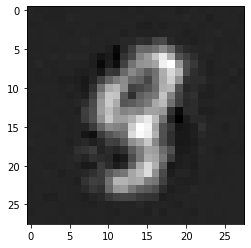

In [68]:
x = np.random.logistic(0,.2, 784)
x = np.reshape(x,(1,784))
x = model(x, inverse=True, pass_inv=True)
x = x.numpy()
plt.imshow(x.reshape(28,28),cmap='gray')
plt.show()